## Try to see if our S2Si threshold is too high. 
Notebook should work fo runs with trigger on s2, set to 600+mus in buffer

In [1]:
import os
import tables as tb
import numpy  as np
from matplotlib import pyplot as plt
from glob import glob

from invisible_cities.cities.irene      import Irene
#from invisible_cities.cities.irene_test import unpack_s12params, s12params
from invisible_cities.reco.params   import S12Params as S12P, PMaps, Peak
from invisible_cities.core.ic_types import minmax
from invisible_cities.core.system_of_units_c import units
from invisible_cities.core.configure         import configure
from invisible_cities.core     import fit_functions    as fit
from invisible_cities.reco     import peak_functions_c as cpf
from invisible_cities.reco     import peak_functions   as  pf
from invisible_cities.io       import pmap_io          as pio
from invisible_cities.database import load_db
from invisible_cities.icaro.mpl_functions import circles
from invisible_cities.filters.s1s2_filter    import s1s2_filter
from invisible_cities.filters.s1s2_filter    import S12Selector

In [2]:
run = 4446
DataSensor  = load_db.DataSiPM(run)
DataPmt     = load_db.DataPMT(run)
active_sipm = DataSensor.Active.values
active_pmt  = DataPmt.Active.values

#### Housekeeping

In [3]:
ic_data = os.path.join(os.environ['IC_DATA'])
rwf_path  = ic_data + 'LSC/wvfms/{}/dst_waves.gdcsnext.1841_{}.root.h5'.format(run, run)
conf_path = '/Users/alej/Desktop/irene/irene.conf'
output_path = '/Users/alej/Desktop/irene/3p5.h5'

In [4]:
# initialize irene
def initialize_irene(output_path, thr_sipm=1.5*units.pes, thr_sipm_s2=20*units.pes, rwf_path=rwf_path):
    PATH_IN  = os.path.join(rwf_path)
    PATH_OUT = os.path.join(output_path)
    conf     = configure(('dummy ' + conf_path).split()).as_dict
    conf.update(dict(run_number = run,
                     files_in   = rwf_path,
                     file_out   = output_path,
                     nmax       = 100000,
                     s1_tmin    = 0))
    irene = Irene(**conf)
    irene.thr_sipm = thr_sipm
    irene.thr_sipm_s2 = thr_sipm_s2
    return irene

In [5]:
irene = initialize_irene(output_path)
irene.s1_params

S12Params(time=minmax(min=0, max=640000.0), stride=4, length=minmax(min=8, max=20), rebin=False)

In [6]:
# Creates a random sorted list of non-repeating valid event numbers
def sample_events(n_sample_events, rwf_path, all_events=False):
    ev_sample = []
    with tb.open_file(rwf_path, 'r+') as f_rwfs:
        events = [f_rwfs.root.Run.events[i][0] for i in range(len(f_rwfs.root.Run.events[:]))]
        if all_events: return events
        ev_sample = np.random.choice(events[1:-1], size=n_sample_events-2, replace=False)
        ev_sample = np.append(np.insert(ev_sample, 0, events[0]), events[-1])
        ev_sample.sort()
        return ev_sample
    
events_f = sample_events(-1, rwf_path, all_events=True)
    
# Get csums for events of pmts and sipms
def calibrated_waveforms(events, irene, rwf_path, pmts=True, sipms=True):
    with tb.open_file(rwf_path ,'r') as f:
        CSUMs  = {}
        csipm  = {}
        for ev in events:
            if pmts : CSUMs[ev] = irene.calibrated_pmt_sum(irene.deconv_pmt(f.root.RD.pmtrwf[ev]))[0]
            if sipms: csipm[ev] = irene.calibrated_signal_sipm(f.root.RD.sipmrwf[ev]).sum(axis=0)
    return CSUMs, csipm

# Mod from invisible_cities.icaro.pmaps_mpl
def plot_s2si_peak_map(s2si_peak, cmap='Blues', subplot=-1, colorbar=True):
        """Plot a map of the energies of S2Si objects."""

        DataSensor = load_db.DataSiPM(0)
        radius = 2
        xs  = DataSensor.X.values[list(s2si_peak.keys())]
        ys  = DataSensor.Y.values[list(s2si_peak.keys())]
        col = [s2si_peak[sipm].sum() for sipm in s2si_peak]
        r   = np.ones(len(xs)) * radius
        
        if subplot !=-1: plt.subplot(subplot, aspect="equal")
        else           : plt.subplot(         aspect="equal")
        circles(xs, ys, r, c=col, alpha=1, ec="none", cmap=cmap)
        if colorbar: plt.colorbar()

        plt.xlim(-250, 250) # this should be fixed in nextic/master
        plt.ylim(-250, 250)

#### First plot some summed S2s when thr_sipm is set to different values

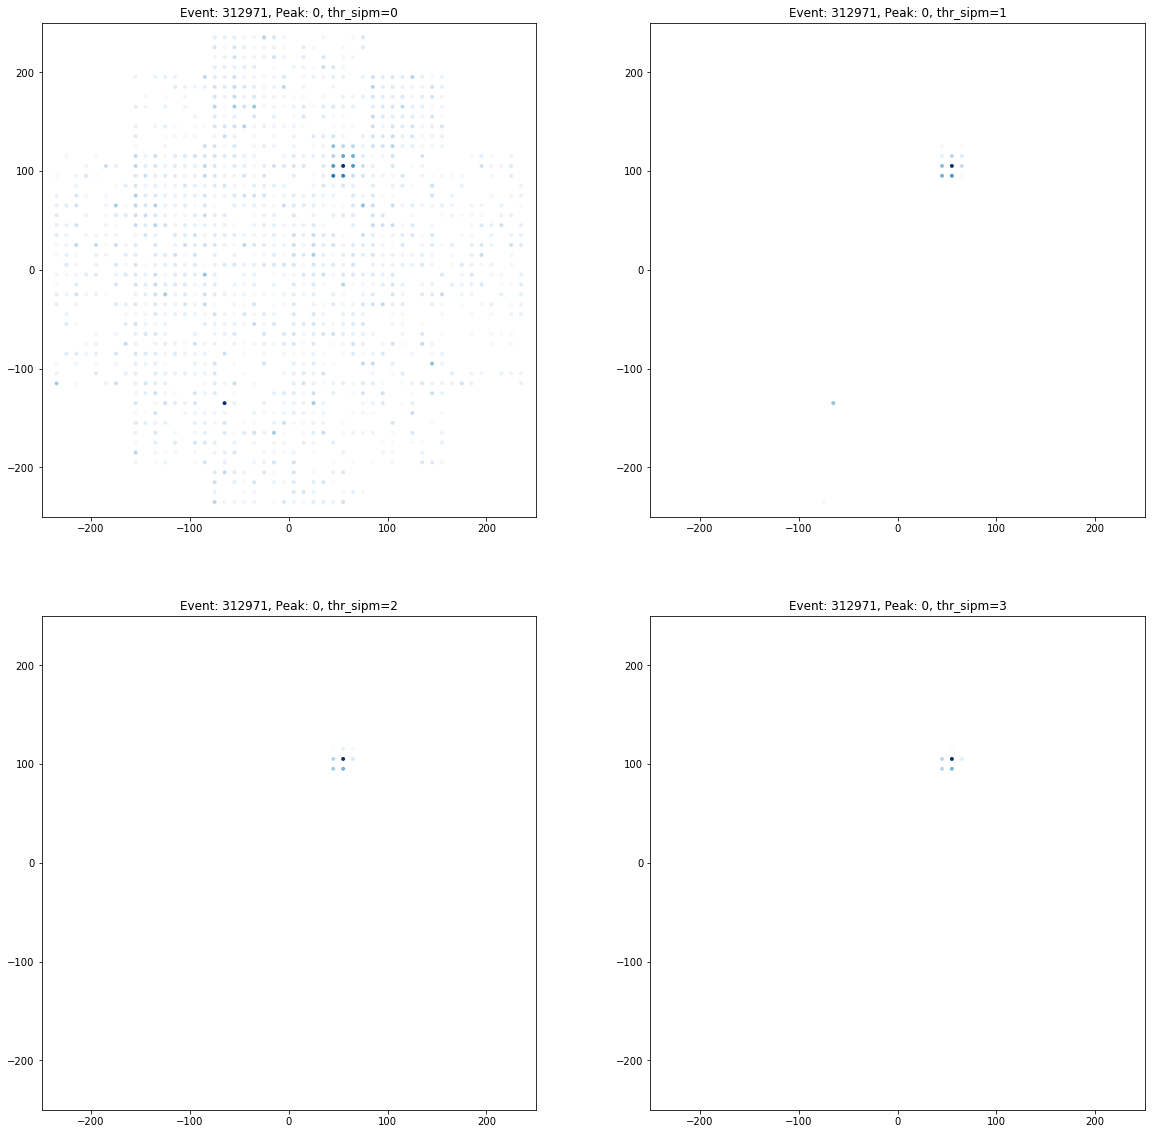

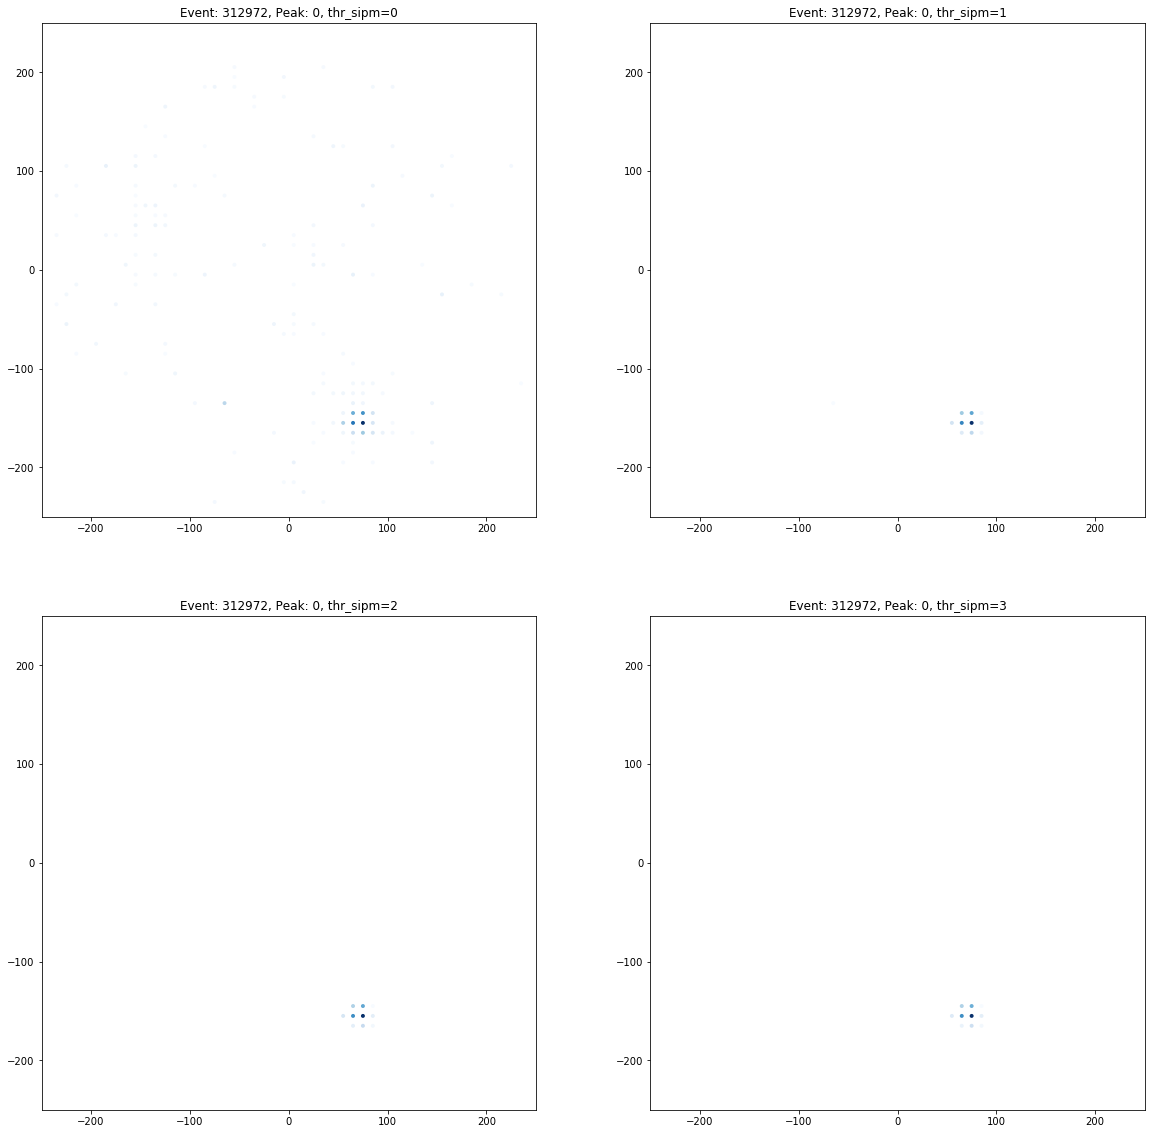

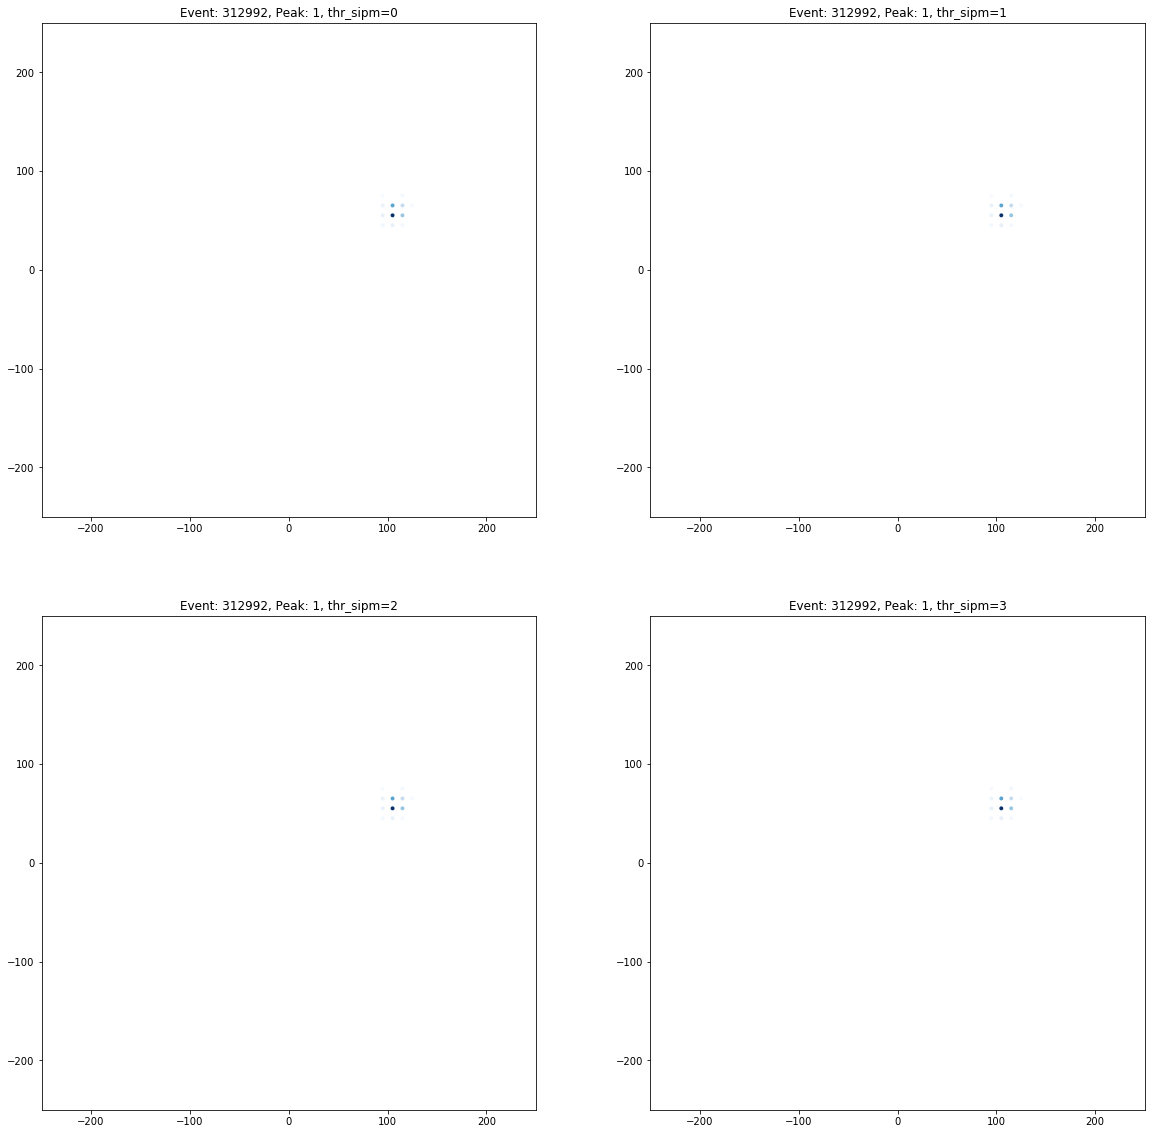

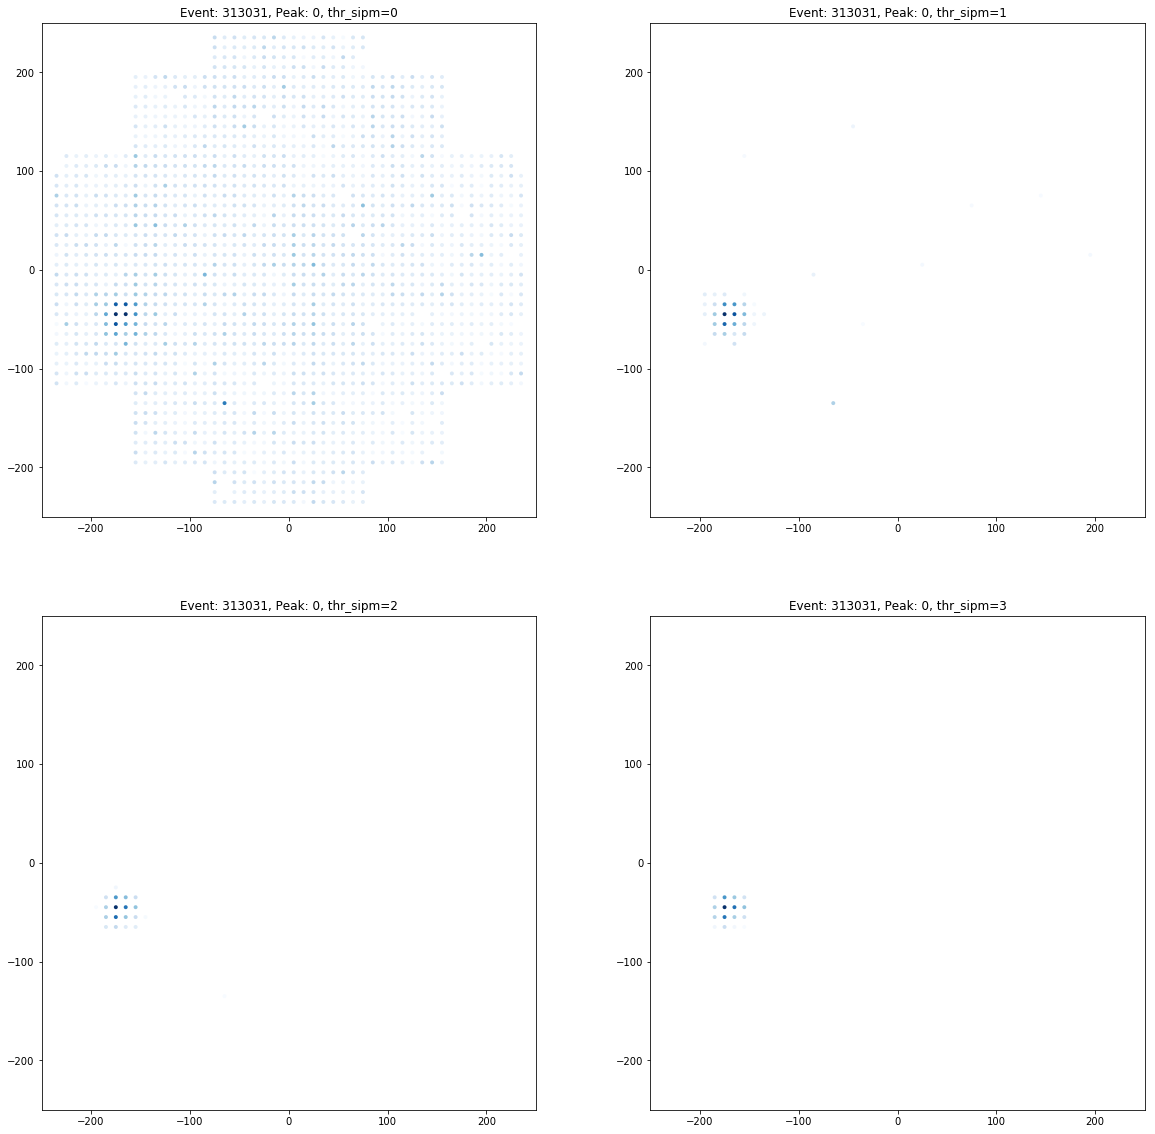

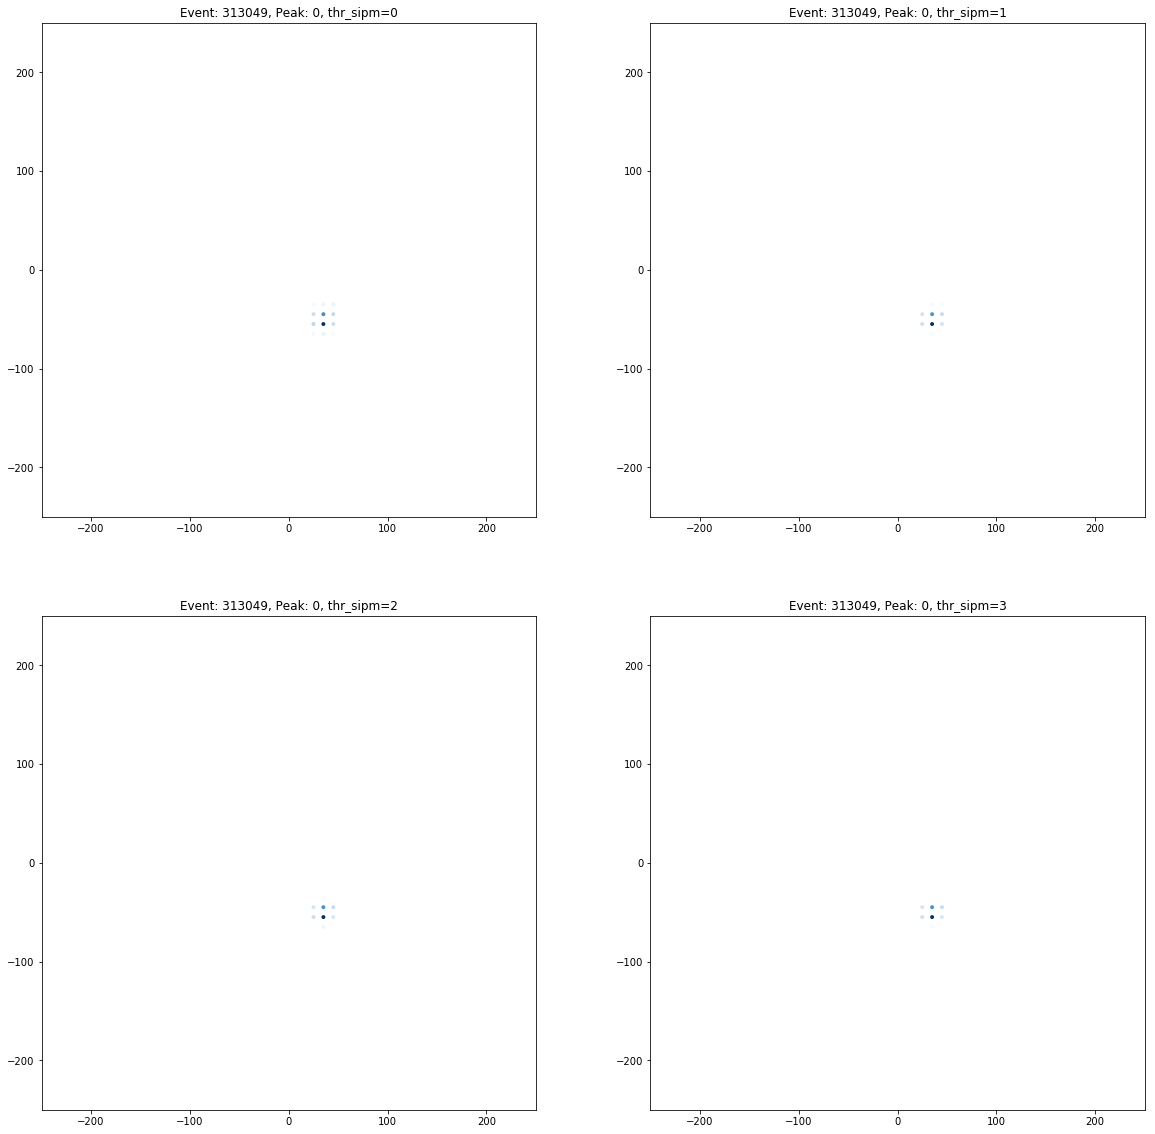

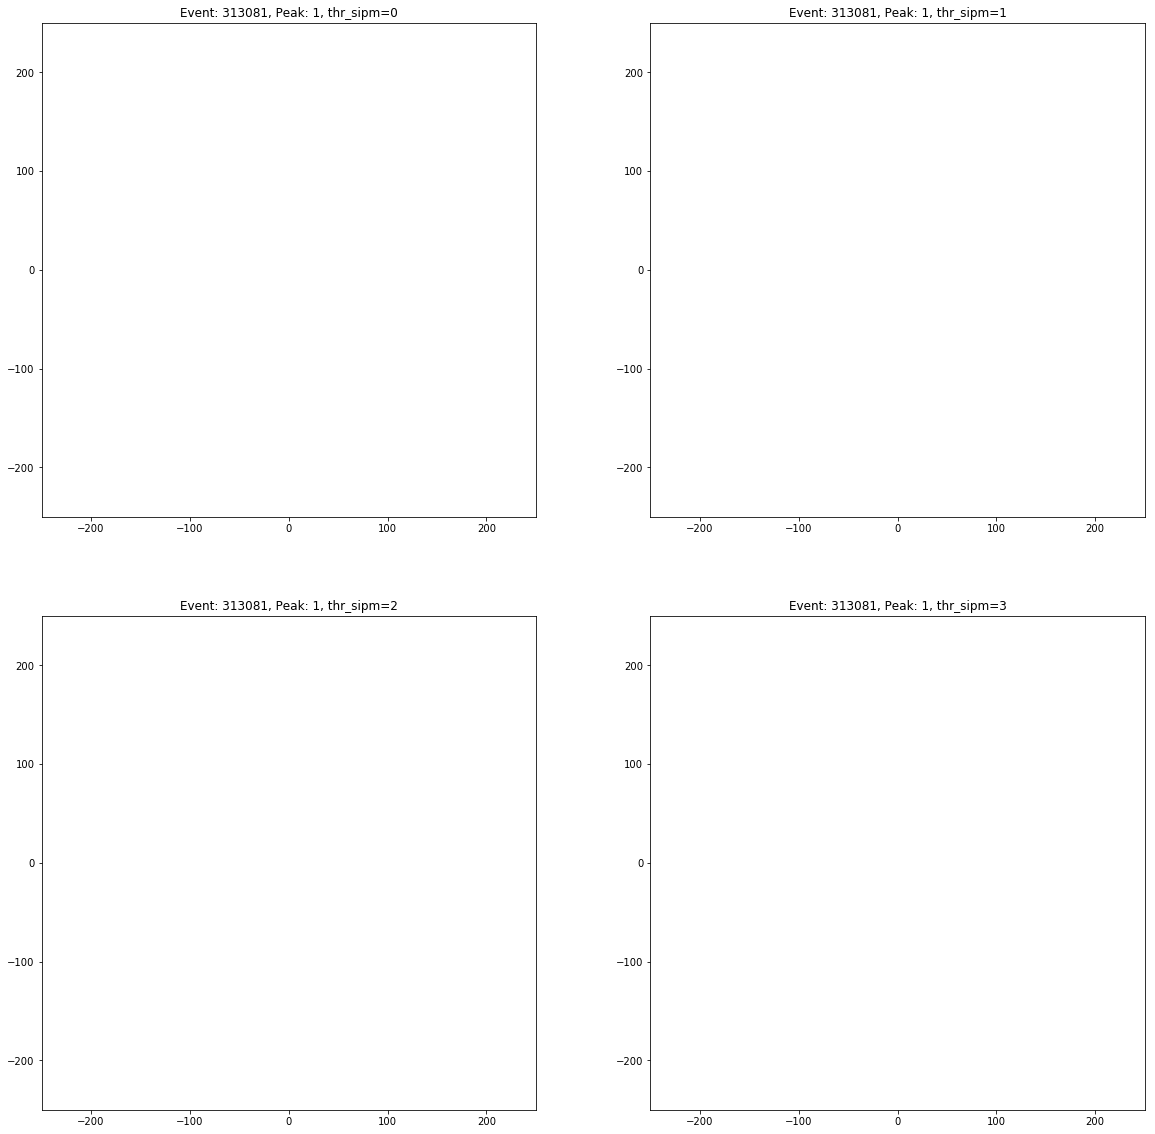

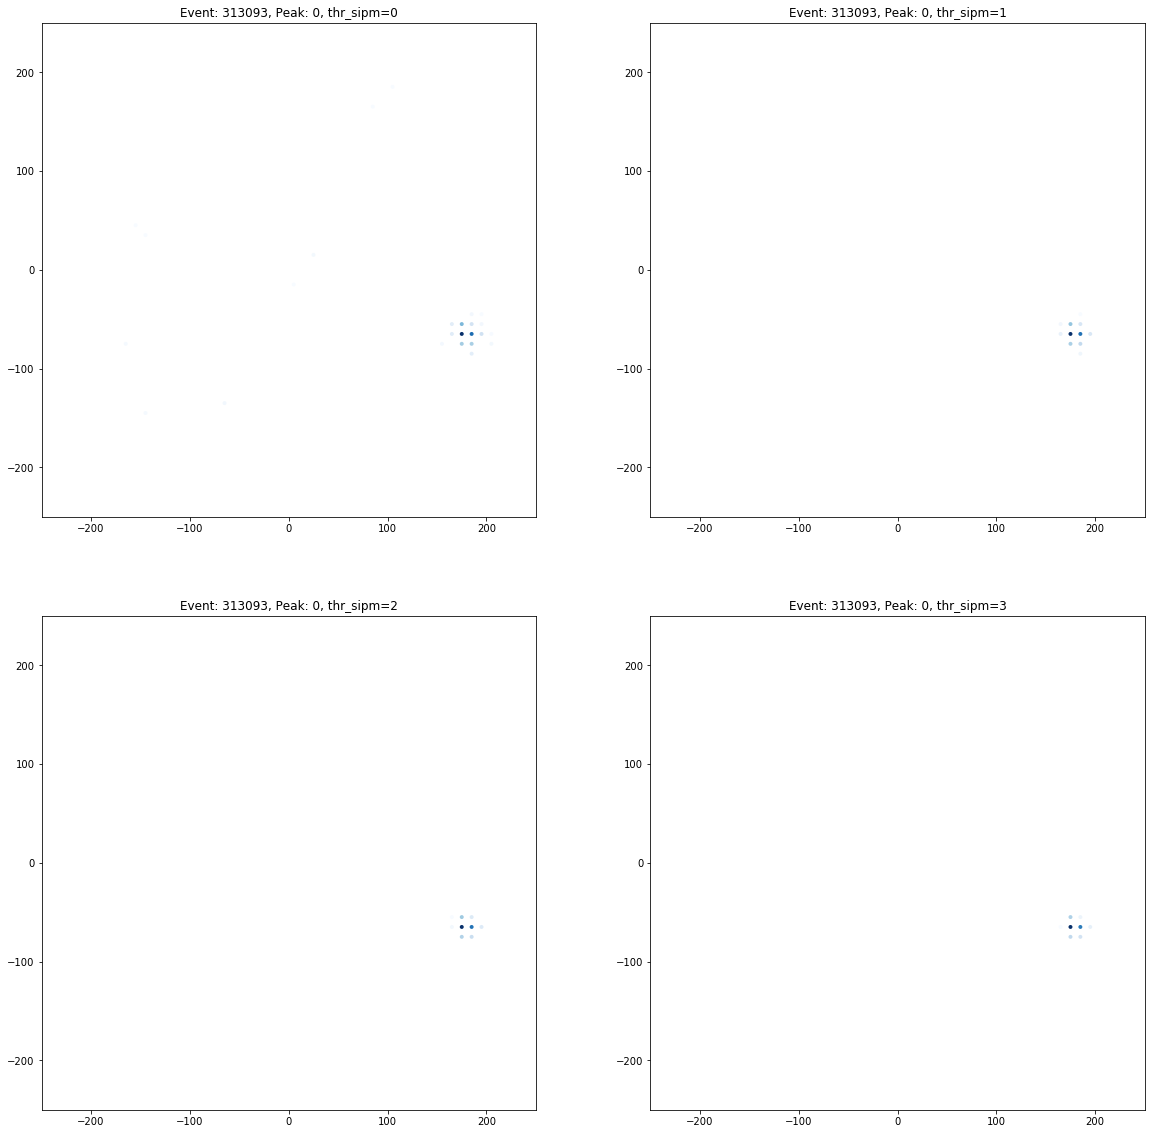

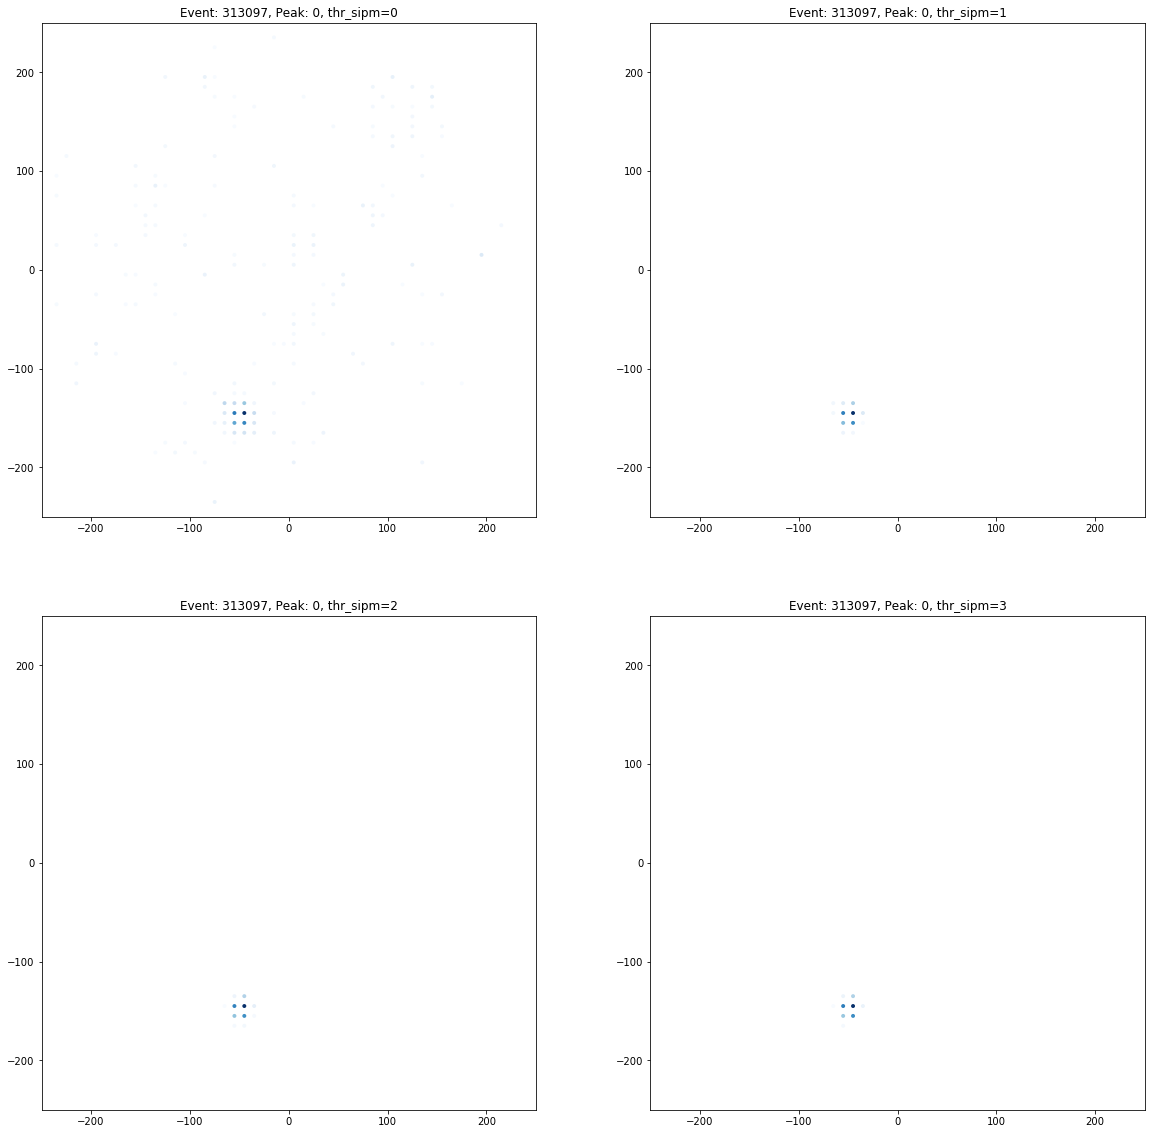

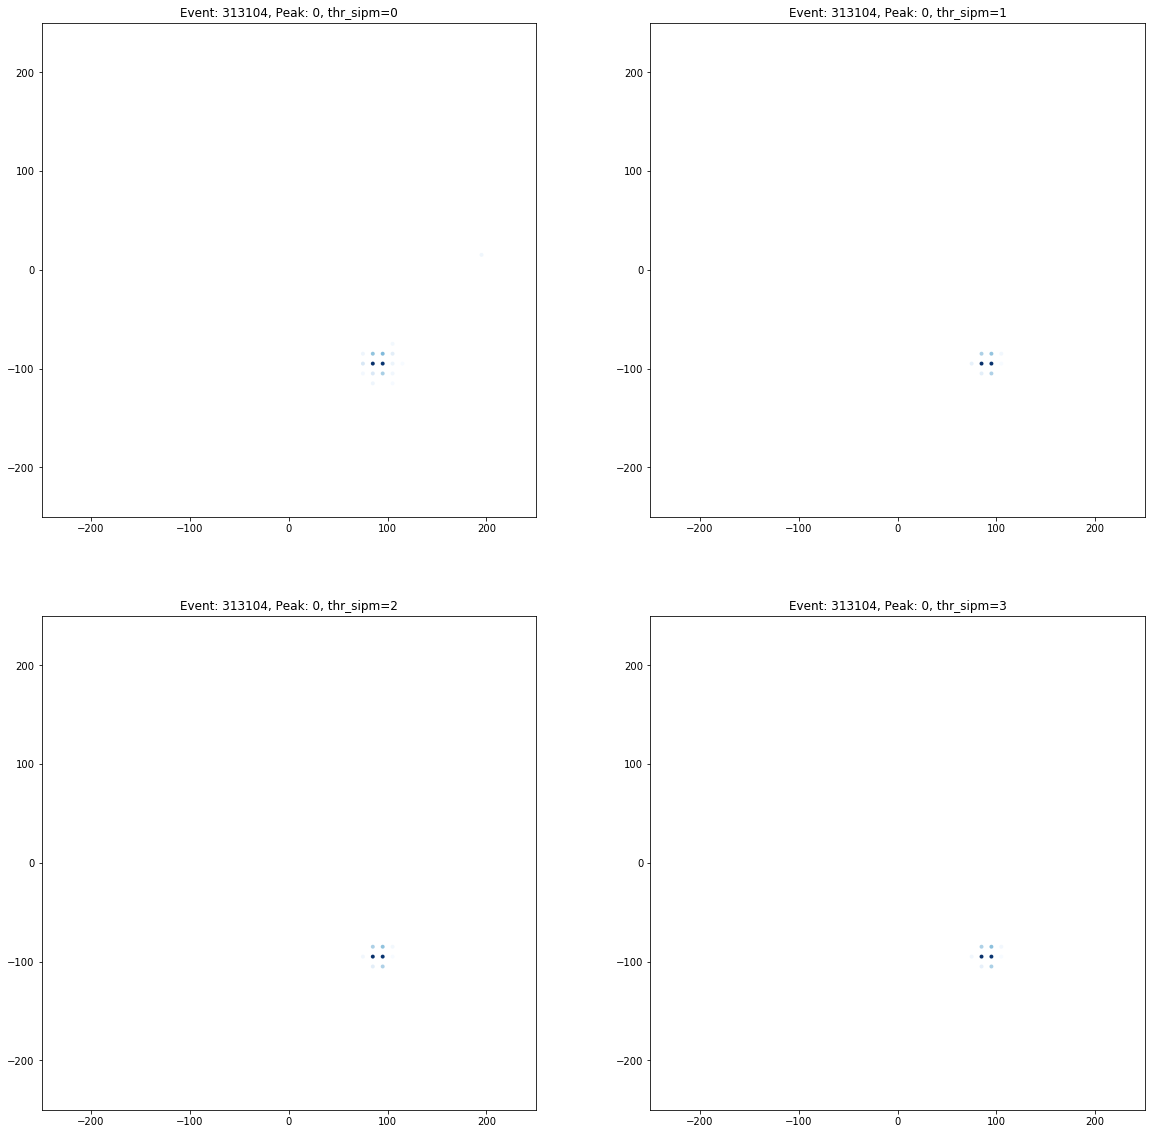

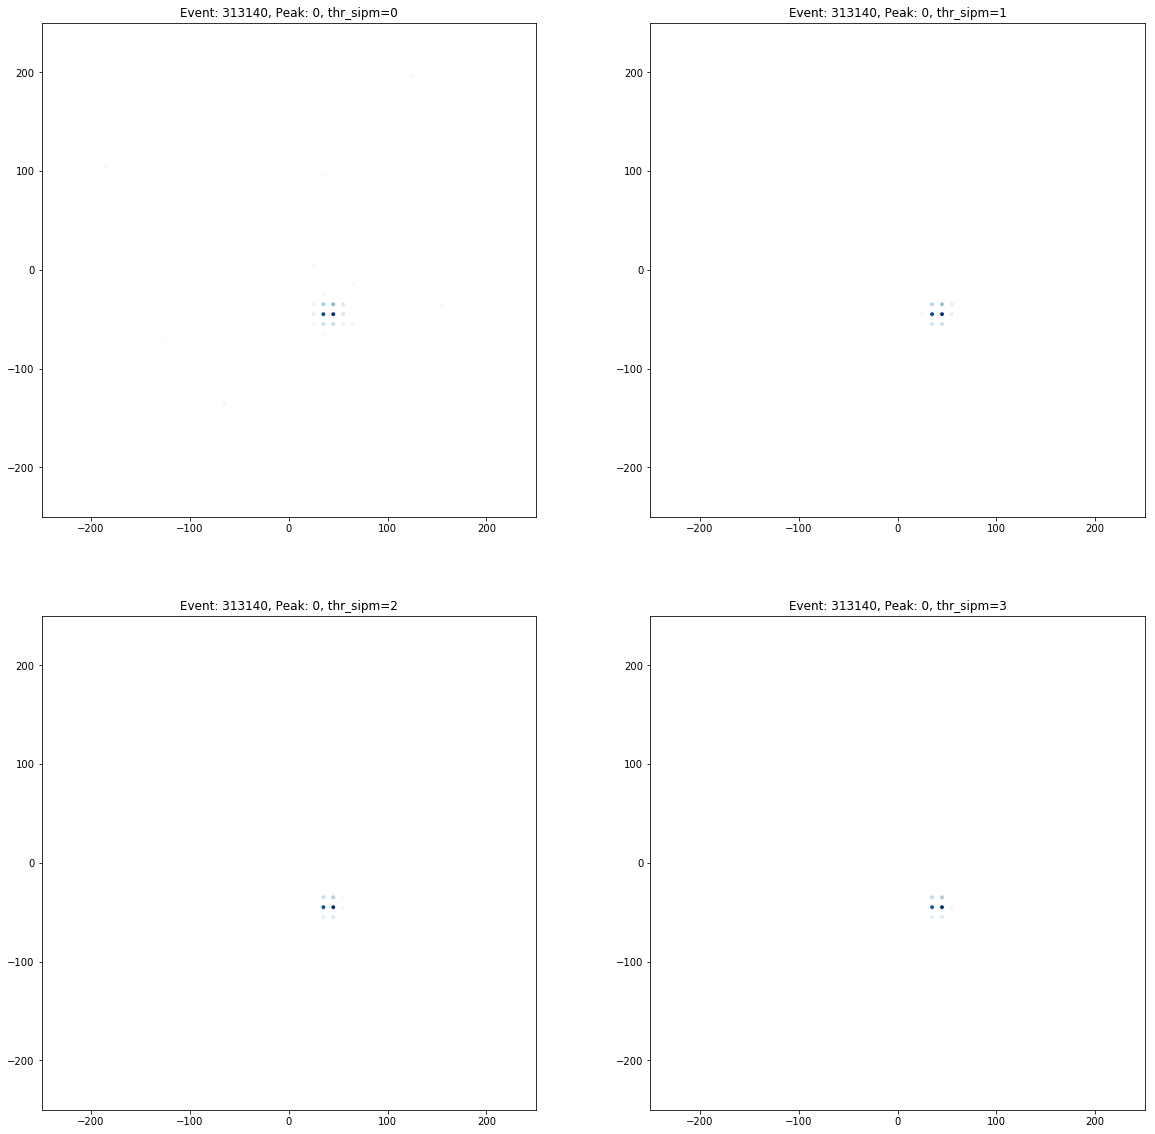

In [7]:
evs  = sample_events(10, rwf_path)
evis = evs - evs[0]
#irene.thr_sipm_s2=20
with tb.open_file(rwf_path, 'r') as f:
    pmtrwf  = f.root.RD. pmtrwf
    sipmrwf = f.root.RD.sipmrwf
    for evt in evis:
        plt.figure(figsize=(20,20))
        subplot=221
        s1_ene, s1_indx, s2_ene, s2_indx, csum = irene.pmt_transformation(pmtrwf[evt])
        for thr_sipm in range(4):
            irene.thr_sipm = thr_sipm
            sipmzs = irene.calibrated_signal_sipm(sipmrwf[evt])
            s1, s2, s2si = irene.pmaps(s1_indx, s2_indx, csum, sipmzs)
            pn = np.array(list(s2si.peaks.keys())).max()
            plt.subplot(subplot)
            plot_s2si_peak_map(s2si.s2sid[pn], cmap='Blues', subplot=subplot, colorbar=False)
            plt.title('Event: ' + str(evt + evs[0]) + ', Peak: ' + str(pn) + ', thr_sipm=' + str(irene.thr_sipm))
            subplot+=1
        plt.show()
        print('======================================================================================================')

Even with the threshold set to 0, were are making a cut somewhere clearly beacuse we don't see little noisy SiPMs and in the s2si there are only a few SiPMs. That said, it looks like 3.5 pes is an excessively high threshold.

#### Look at baseline s2si in the waveform when there is no s2 (and preferably no s1 either), figure out avg value + some sigma and set threshold there?

In [8]:
irene.thr_sipm=3.5
def get_rid_of_peaks(wf, s12, buff=2*units.mus):
    for p in s12.peaks:
        (t0, t1) = s12.peaks[p].tmin_tmax
        t0 = np.floor(t0) - buff
        t1 = np.ceil(t1)  + buff
        i0 = int(t0 / units.mus)
        i1 = int(t1 / units.mus)
        return np.concatenate((wf[:i0], wf[i1:])) # may give index error

evs  = sample_events(-1, rwf_path,all_events=True)
evis = evs - evs[0]
avg_baseline = []
#irene.thr_sipm_s2=20
with tb.open_file(rwf_path, 'r') as f:
    pmtrwf  = f.root.RD. pmtrwf
    sipmrwf = f.root.RD.sipmrwf
    for evt in evis:
        s1_ene, s1_indx, s2_ene, s2_indx, csum = irene.pmt_transformation(pmtrwf[evt])
        sipmzs = irene.calibrated_signal_sipm(sipmrwf[evt][active_sipm==1])
        s1, s2, s2si = irene.pmaps(s1_indx, s2_indx, csum, sipmzs)
        skip=False
        for p in s1.peaks:
            if s1.peaks[p].t[-1] > 500*units.mus: skip=True
        if not skip:
            wf = get_rid_of_peaks(sipmzs.mean(axis=0), s2)
            wf = wf[wf < 50*units.pes] # This should only happen if there is a real s2
            avg_baseline.append(wf.mean())

#### Avg signal in one sipm in one time bin NOT during an S2

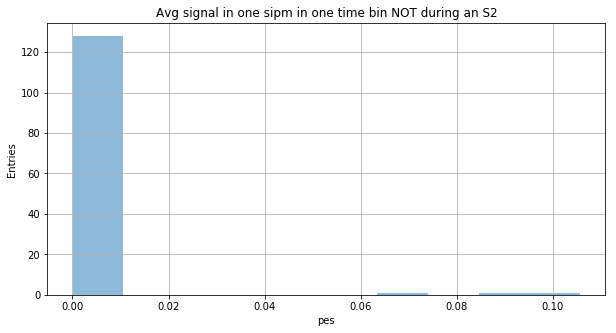

In [9]:
plt.figure(figsize=(10,5))
plt.hist(avg_baseline, alpha=.5)
plt.grid(True)
plt.title('Avg signal in one sipm in one time bin NOT during an S2')
plt.xlabel('pes')
plt.ylabel('Entries')
plt.show()

#### Quick look at avg waveforms

In [10]:
tc = 400

irene.thr_sipm=0
evs  = sample_events(-1, rwf_path,all_events=True)
evis = evs - evs[0]
avg_pre_s1 = np.zeros(tc        , dtype=np.float32)
pre_s1     = np.zeros((len(active_sipm[active_sipm==1]), tc), dtype=np.float32)
pre_s1_tb  = []
evc = 0
with tb.open_file(rwf_path, 'r') as f:
    pmtrwf  = f.root.RD. pmtrwf
    sipmrwf = f.root.RD.sipmrwf
    for evt in evis:
        s1_ene, s1_indx, s2_ene, s2_indx, csum = irene.pmt_transformation(pmtrwf[evt])
        sipmzs = irene.calibrated_signal_sipm(sipmrwf[evt][active_sipm==1])
        s1, s2, s2si = irene.pmaps(s1_indx, s2_indx, csum, sipmzs)

        # Skip all events that have a peak before 300 mus in the pmts
        skip=False
        if csum[:tc].max() > .5: 
            continue           
        for s12 in [s1, s2]:
            for p in s12.peaks:
                if s12.peaks[p].t[0] < tc*units.mus: 
                    skip=True
                    break
        if skip: continue
        else: 
            pre_s1 += sipmzs[:,:tc]
            avg_pre_s1 += pre_s1.mean(axis=0)
            pre_s1_tb.extend(sipmzs[:,:tc].flatten())
            evc += 1
    
avg_pre_s1 /= evc
pre_s1 /= evc

Number of events: 70


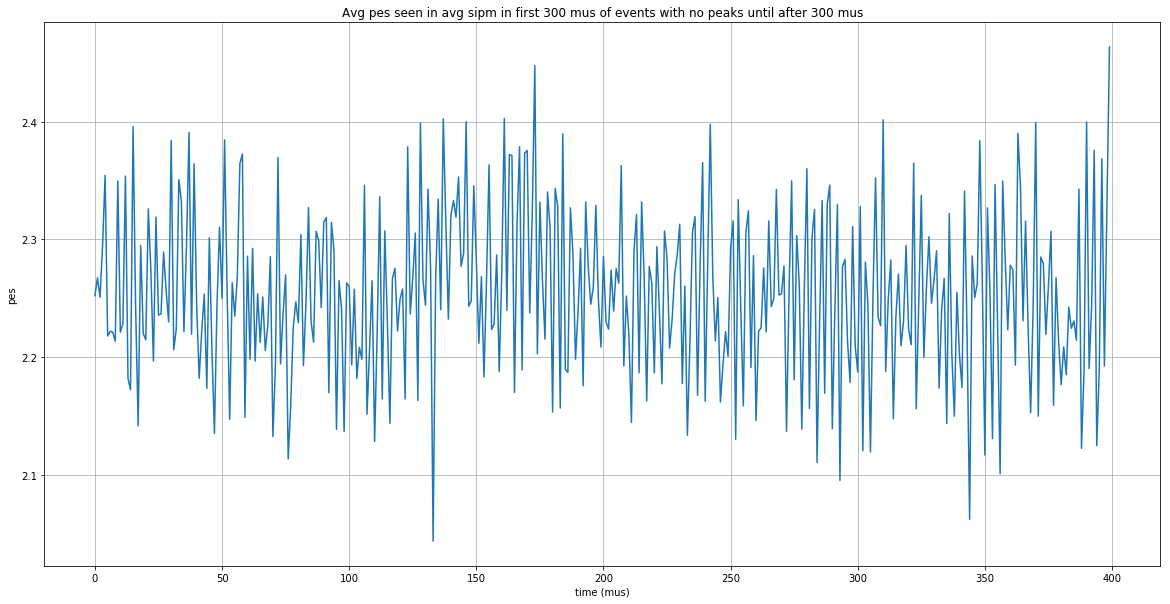

In [11]:
print('Number of events:', evc)
plt.figure(figsize=(20, 10))
plt.plot(np.arange(tc), avg_pre_s1)
plt.grid(True)
plt.title('Avg pes seen in avg sipm in first 300 mus of events with no peaks until after 300 mus')
plt.ylabel('pes')
plt.xlabel('time (mus)')
plt.show()

Number of events: 70


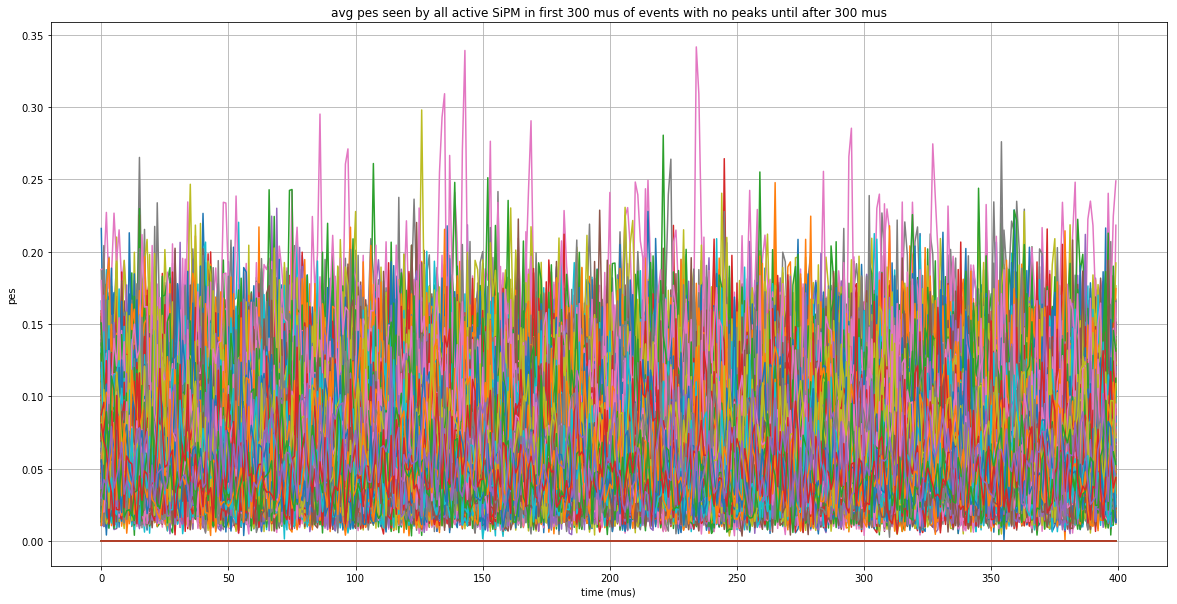

In [12]:
print('Number of events:', evc)
plt.figure(figsize=(20, 10))
for sipm in pre_s1:
    plt.plot(np.arange(tc), sipm)
plt.grid(True)
plt.title('avg pes seen by all active SiPM in first 300 mus of events with no peaks until after 300 mus')
plt.ylabel('pes')
plt.xlabel('time (mus)')
plt.show()

#### All of this looks promising. But the analysis is not great because by taking the average waveform I am averaging out the noise I am looking for. I'm underestimating the noise. (Still at .05 pes is two orders of magnitude away from our 3.5 threshold)

N time bins: 49980000


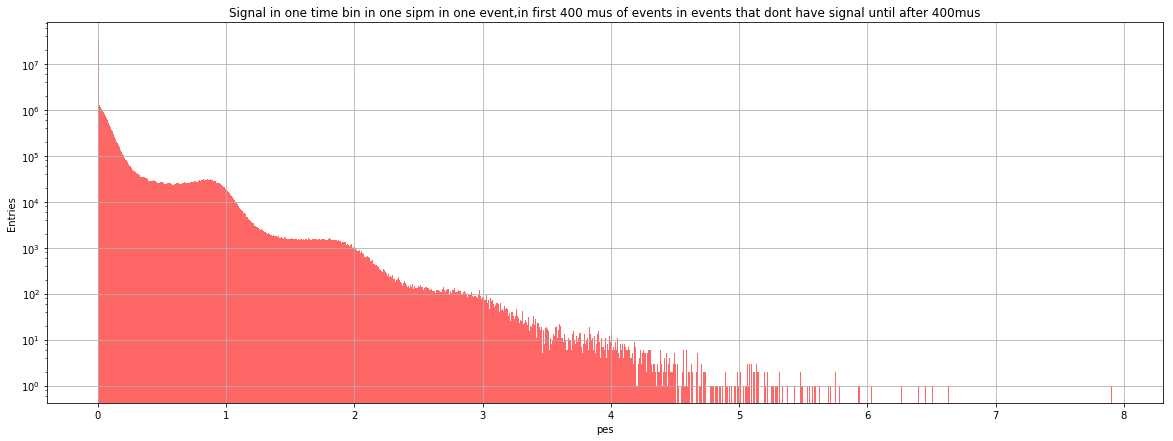

In [13]:
print('N time bins:', len(pre_s1_tb))
plt.figure(figsize=(20,7))
pre_s1_tb=np.array(pre_s1_tb)
plt.hist(pre_s1_tb, alpha=.6, bins=1000, color='red')
plt.grid(True)
plt.title(\
'Signal in one time bin in one sipm in one event,in first 400 mus of events in events that dont have signal until after 400mus')
plt.xlabel('pes')
plt.ylabel('Entries')
plt.yscale('log')
#plt.xlim(0.5,0.75)
#plt.ylim(0,70000)
plt.show()

The plot shows first:
If there is no signal detected by the PMTs there is a 1/10^3 chance an SiPM will record 1 pes+ and a 1/10^5 chance it will record 2 pes+ in one time bin. 

The bumps, one pes apart, show that the SiPMs are calibrated well record values corresponding to whole number pes.

#### So, now we know how much noise we are getting if we put `sipm_thr` at 1 pes, 2 pes, etc, need to figure out how much signal we are throwing out.

    1) Make pmaps with various sipm_thr
    2) Use dorotea like functions to select Kr candidates
    3) Track efficiency (in some form) as a function of sipm_thr, particularly for events at large drift times

#### First make pmaps with a few different thresholds

In [14]:
generate_set_of_pmaps = False # Dont accidentally run / overwrite
if generate_set_of_pmaps:
    trial_thr_sipms = np.arange(0, 40, 2)
    for thr_sipm_s2 in trial_thr_sipms:
        irene = initialize_irene(
            '/Users/alej/Desktop/irene/irene_pmaps_s2thr_{}.h5'.format(thr_sipm_s2), 
            thr_sipm=1.5, thr_sipm_s2=thr_sipm_s2)
        irene.run()

#### For each of these pmap files extract Kr candidates

In [15]:
def get_candidate_pmaps(pmap_path):
    candidates = []
    s1_dict, s2_dict, s2si_dict = pio.load_pmaps(pmap_path)
    for evt_number in s1_dict: # ignores events without S1
        s1, s2, s2si = pio.s1_s2_si_from_pmaps(s1_dict, s2_dict, s2si_dict, evt_number)
        
        # WRITE CUTS HERE
        if s1 == None or s2 == None or s2si == None: continue
        if len(s1.peaks) > 1 or len(s2.peaks) > 1 or len(s2si.peaks) > 1: continue
        candidates.append((s1, s2, s2si))
        
    return candidates  

#### Check for losses of signal  in pmaps with higher thr_sipm

In [17]:
pmap_paths = glob('/Users/alej/Desktop/irene/irene_pmaps_[0-9].h5')
PMAPS = [get_candidate_pmaps(f) for f in pmap_paths]
naccepted = [len(pmaps) for pmaps in PMAPS]
for i in range(len(PMAPS)): print('Accepted Events:', naccepted[i], 'with thr_sipm=' + str(i))

Accepted Events: 73 with thr_sipm=0
Accepted Events: 73 with thr_sipm=1
Accepted Events: 73 with thr_sipm=2
Accepted Events: 73 with thr_sipm=3
Accepted Events: 73 with thr_sipm=4
Accepted Events: 73 with thr_sipm=5
Accepted Events: 72 with thr_sipm=6
Accepted Events: 70 with thr_sipm=7
Accepted Events: 67 with thr_sipm=8
Accepted Events: 64 with thr_sipm=9


#### Check s2si integral Q as a function of drift time (or s1 time)

In [47]:
def get_features_from_PMAPS(PMAPS, DTS=None, 
                                    QS=None, 
                                    qs=None): 
    
    if DTS is None: DTS = [[] for pmaps in PMAPS]
    if QS  is None: QS  = [[] for pmaps in PMAPS]
    if qs  is None: qs  = [[] for pmaps in PMAPS]
    
    for i, pmaps in enumerate(PMAPS):
        for s1, s2, s2si in pmaps:
            DTS[i].append(s2.peaks[0].tpeak - s1.peaks[0].tpeak)
            Q_sipm_dict = s2si.sipm_total_energy_dict(0)
            tqs = [qs for qs in Q_sipm_dict.values()]
            qs[i].extend(tqs)
            QS[i].append(np.sum(tqs))
    return DTS, QS, qs

def get_s2_width_from_pmaps(pmaps, S2_widths=[]):
    for _, s2, _ in pmaps: S2_widths.append(s2.peaks[0].width)
    return S2_widths
        
            

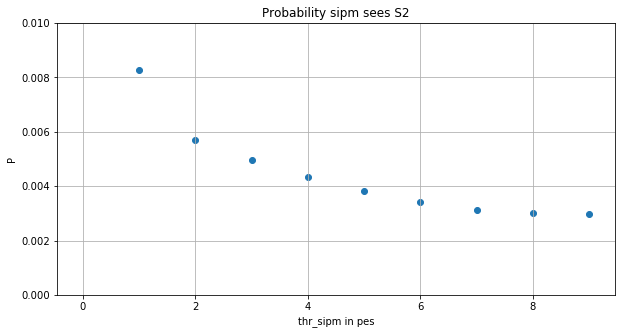

In [21]:
DTS, QS, qs = get_features_from_PMAPS(PMAPS)
trial_thr_sipms = 10
plt.figure(figsize=(10,5))
plt.scatter(range(trial_thr_sipms), np.array([len(qsi) / (1785 * naccepted[i]) for i, qsi in enumerate(qs)]))
#plt.xlim(1,9)
plt.ylim(0,.01)
#plt.yscale('log')
plt.title('Probability sipm sees S2')
plt.ylabel('P')
plt.xlabel('thr_sipm in pes')
plt.grid(True)
plt.show()

It would be nice to make this plot as a heatmap/2d hist where one axis is thr_sipm and one is thr_sipm_s2 but that requires running irene once for each set of parameters, probably over a few rwf files.

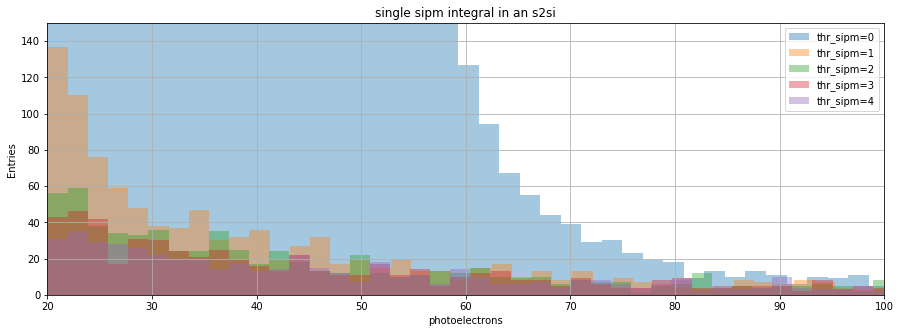

thr_s2: 0 sipms that saw an S2 in this file 60524
thr_s2: 1 sipms that saw an S2 in this file 1079
thr_s2: 2 sipms that saw an S2 in this file 742
thr_s2: 3 sipms that saw an S2 in this file 645
thr_s2: 4 sipms that saw an S2 in this file 566
thr_s2: 5 sipms that saw an S2 in this file 500
thr_s2: 6 sipms that saw an S2 in this file 437
thr_s2: 7 sipms that saw an S2 in this file 388
thr_s2: 8 sipms that saw an S2 in this file 362
thr_s2: 9 sipms that saw an S2 in this file 339


In [22]:
plt.figure(figsize=(15,5))
plot_thr_sipms = range(0,5)
for i in plot_thr_sipms:
    plt.hist(qs[i], bins=200, alpha=.4, label='thr_sipm=' + str(i), normed=False)
    plt.title('single sipm integral in an s2si')
    plt.xlabel('photoelectrons')
    plt.ylabel('Entries')
    #plt.yscale('log')
    plt.ylim(0, 150)
    plt.xlim(irene.thr_sipm_s2, 100)
    plt.grid(True)
    plt.legend()
plt.show()
for i, qsi in enumerate(qs): print('thr_s2:',i,'sipms that saw an S2 in this file', len(qsi))

#### Noise should be not dependent on drift time, but signal is. Look at QS vs DTS, but we need more than 73 evts.

In [23]:
generate_set_of_pmaps = False # Dont accidentally run / overwrite
if generate_set_of_pmaps:
    trial_thr_sipms = np.arange(0, 3, .5)
    for i, rwf_path in enumerate(glob(ic_data + 'LSC/wvfms/{}/dst_waves.gdcsnext.*_{}.root.h5'.format(run, run))):
        for thr_sipm in trial_thr_sipms:
            irene = initialize_irene(
                '/Users/alej/Desktop/irene/{}/irene_pmaps_{}.h5'.format(i, thr_sipm),
                rwf_path=rwf_path, 
                thr_sipm=thr_sipm, 
                thr_sipm_s2=20)
            irene.run()

In [26]:
thrs = np.arange(0, 3, .5)

QS   = [[] for thr in thrs]
qs   = [[] for thr in thrs]
DTS  = [[] for thr in thrs]

for rwf_fn in range(10):
    PMAPS = []
    for thr_sipm in thrs:
        pmap_path = '/Users/alej/Desktop/irene/{}/irene_pmaps_{}.h5'.format(rwf_fn, thr_sipm)
        print(pmap_path)
        PMAPS.append(get_candidate_pmaps(pmap_path))
        
    DTS, QS, qs = get_features_from_PMAPS(PMAPS, DTS=DTS, QS=QS, qs=qs)

/Users/alej/Desktop/irene/0/irene_pmaps_0.0.h5
/Users/alej/Desktop/irene/0/irene_pmaps_0.5.h5
/Users/alej/Desktop/irene/0/irene_pmaps_1.0.h5
/Users/alej/Desktop/irene/0/irene_pmaps_1.5.h5
/Users/alej/Desktop/irene/0/irene_pmaps_2.0.h5
/Users/alej/Desktop/irene/0/irene_pmaps_2.5.h5
/Users/alej/Desktop/irene/1/irene_pmaps_0.0.h5
/Users/alej/Desktop/irene/1/irene_pmaps_0.5.h5
/Users/alej/Desktop/irene/1/irene_pmaps_1.0.h5
/Users/alej/Desktop/irene/1/irene_pmaps_1.5.h5
/Users/alej/Desktop/irene/1/irene_pmaps_2.0.h5
/Users/alej/Desktop/irene/1/irene_pmaps_2.5.h5
/Users/alej/Desktop/irene/2/irene_pmaps_0.0.h5
/Users/alej/Desktop/irene/2/irene_pmaps_0.5.h5
/Users/alej/Desktop/irene/2/irene_pmaps_1.0.h5
/Users/alej/Desktop/irene/2/irene_pmaps_1.5.h5
/Users/alej/Desktop/irene/2/irene_pmaps_2.0.h5
/Users/alej/Desktop/irene/2/irene_pmaps_2.5.h5
/Users/alej/Desktop/irene/3/irene_pmaps_0.0.h5
/Users/alej/Desktop/irene/3/irene_pmaps_0.5.h5
/Users/alej/Desktop/irene/3/irene_pmaps_1.0.h5
/Users/alej/D

In [37]:
def plot_pes_v_drift_time_for_thrs(QS, DTS, thrs, s=0, f=None, xlim=None, ylim=None, thr_name='thr_sipm'):
    plt.figure(figsize=(15,5))
    for i, thr in  enumerate(thrs[s:f]): 
        indx =i+s
        plt.scatter(np.array(DTS[indx]) / units.mus, QS[indx], label=thr_name+'='+str(thr)+'pes')
        if xlim is not None: plt.xlim(xlim)
        if ylim is not None: plt.ylim(ylim)
        plt.ylabel('pes')
        plt.xlabel('drift time')
        plt.title('total pes in s2si peak')
        plt.legend()
        plt.grid(True)
    plt.show()

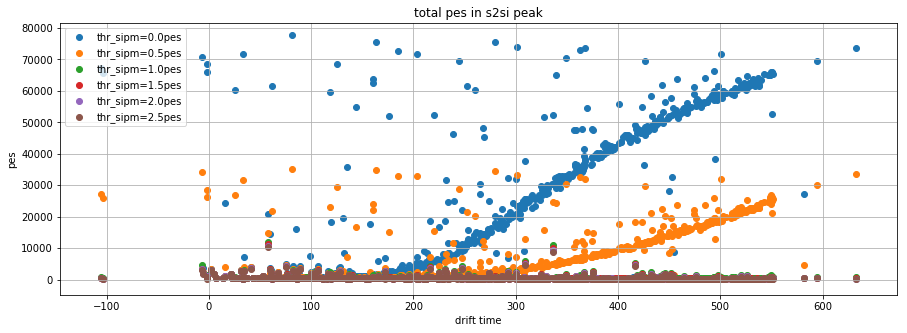

In [28]:
plot_pes_v_drift_time_for_thrs(QS, DTS, thrs, s=0, f=len(QS), xlim=None, ylim=None)

Why do pes explode by orders of magnitude as drift time increases?

In [54]:
#pmaps = PMAPS[0] # s2 width the same in each set of pmaps in PMAPS
#dts   = DTS  [4] # dido
#print(len(dts), len(get_s2_width_from_pmaps(pmaps)))
#plt.scatter(dts, get_s2_width_from_pmaps(pmaps))

We do not want to set the threshold at <= 1pes

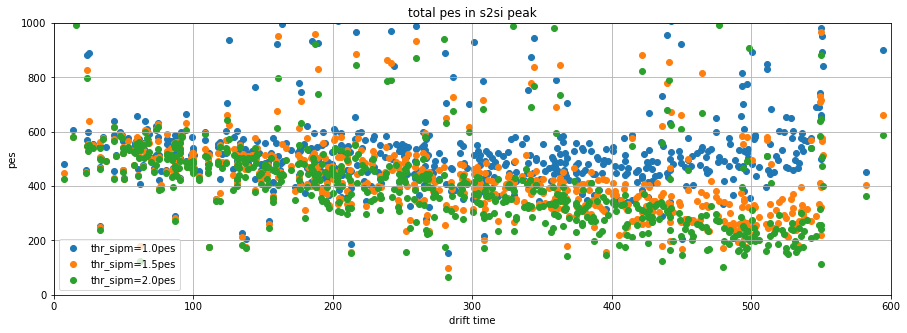

In [29]:
plot_pes_v_drift_time_for_thrs(QS, DTS, thrs, s=2, f=None, xlim=(0,600), ylim=(0,1e3))

In this plot for sufficiently hard cuts, we should see charge decrease with drift time because of attachment.    
With cuts that are too lenient, we should see an increase in charge with drift time, as in the plot above.  

In [31]:
generate_set_of_pmaps = False # Dont accidentally run / overwrite
if generate_set_of_pmaps:
    trial_thr_sipms_s2 = np.arange(0, 40, 5)
    for i, rwf_path in enumerate(glob(ic_data + 'LSC/wvfms/{}/dst_waves.gdcsnext.*_{}.root.h5'.format(run, run))):
        for thr_sipm_s2 in trial_thr_sipms_s2:
            irene = initialize_irene(
                '/Users/alej/Desktop/irene/{}/irene_pmaps_s2_{}.h5'.format(i, thr_sipm_s2),
                rwf_path=rwf_path, 
                thr_sipm=1.5*units.pes, 
                thr_sipm_s2=thr_sipm_s2)
            irene.run()


                 Irene will run a max of 100000 events
                 Input Files = ['/Users/alej/Desktop/IC_DATA/LSC/wvfms/4446/dst_waves.gdcsnext.1840_4446.root.h5']
                 Output File = /Users/alej/Desktop/irene/0/irene_pmaps_s2_0.h5
                          

                 S1 parameters S12Params(time=minmax(min=0, max=640000.0), stride=4, length=minmax(min=8, max=20), rebin=False)

                 S2 parameters S12Params(time=minmax(min=650000.0, max=750000.0), stride=40, length=minmax(min=100, max=100000), rebin=True)

                 S2Si parameters
                 threshold min charge per SiPM = 1.5 pes
                 threshold min charge in  S2   = 0 pes
                          
####################
SensorParams
####################
npmt: 12
pmtwl: 52000
nsipm: 1792
sipmwl: 1300

Opening /Users/alej/Desktop/IC_DATA/LSC/wvfms/4446/dst_waves.gdcsnext.1840_4446.root.h5... event in file = 0, total = 1
event in file = 1, total = 2
event in file = 2, total = 

In [34]:
thrs_sipm_s2 = np.arange(0, 40, 5)
QS   = [[] for thr in thrs_sipm_s2]
qs   = [[] for thr in thrs_sipm_s2]
DTS  = [[] for thr in thrs_sipm_s2]

for rwf_fn in range(10):
    PMAPS = []
    for thr_sipm_s2 in thrs_sipm_s2:
        pmap_path = '/Users/alej/Desktop/irene/{}/irene_pmaps_s2_{}.h5'.format(rwf_fn, thr_sipm_s2)
        print(pmap_path)
        PMAPS.append(get_candidate_pmaps(pmap_path))

    DTS, QS, qs = get_features_from_PMAPS(PMAPS, DTS=DTS, QS=QS, qs=qs)

/Users/alej/Desktop/irene/0/irene_pmaps_s2_0.h5
/Users/alej/Desktop/irene/0/irene_pmaps_s2_5.h5
/Users/alej/Desktop/irene/0/irene_pmaps_s2_10.h5
/Users/alej/Desktop/irene/0/irene_pmaps_s2_15.h5
/Users/alej/Desktop/irene/0/irene_pmaps_s2_20.h5
/Users/alej/Desktop/irene/0/irene_pmaps_s2_25.h5
/Users/alej/Desktop/irene/0/irene_pmaps_s2_30.h5
/Users/alej/Desktop/irene/0/irene_pmaps_s2_35.h5
/Users/alej/Desktop/irene/1/irene_pmaps_s2_0.h5
/Users/alej/Desktop/irene/1/irene_pmaps_s2_5.h5
/Users/alej/Desktop/irene/1/irene_pmaps_s2_10.h5
/Users/alej/Desktop/irene/1/irene_pmaps_s2_15.h5
/Users/alej/Desktop/irene/1/irene_pmaps_s2_20.h5
/Users/alej/Desktop/irene/1/irene_pmaps_s2_25.h5
/Users/alej/Desktop/irene/1/irene_pmaps_s2_30.h5
/Users/alej/Desktop/irene/1/irene_pmaps_s2_35.h5
/Users/alej/Desktop/irene/2/irene_pmaps_s2_0.h5
/Users/alej/Desktop/irene/2/irene_pmaps_s2_5.h5
/Users/alej/Desktop/irene/2/irene_pmaps_s2_10.h5
/Users/alej/Desktop/irene/2/irene_pmaps_s2_15.h5
/Users/alej/Desktop/irene/

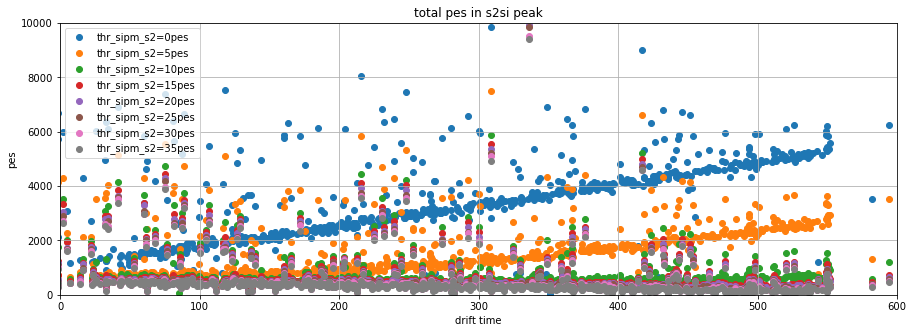

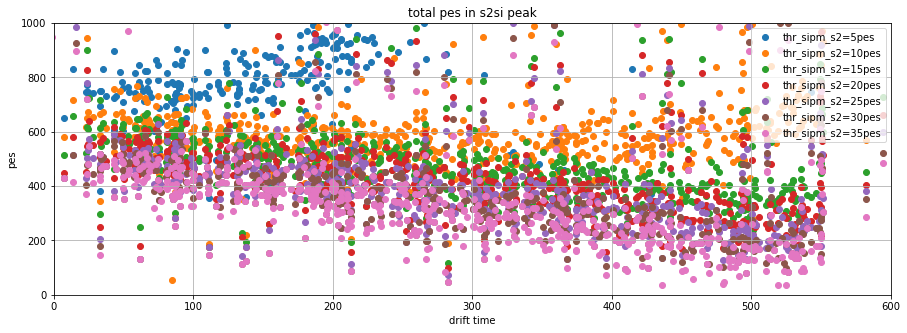

In [43]:
plot_pes_v_drift_time_for_thrs(QS, DTS, thrs_sipm_s2, s=0, f=len(QS), xlim=(0,600), ylim=(0,1e4), thr_name='thr_sipm_s2')
plot_pes_v_drift_time_for_thrs(QS, DTS, thrs_sipm_s2, s=1, f=None   , xlim=(0,600), ylim=(0,1e3), thr_name='thr_sipm_s2')

We are going to reproduce this plot with thr_sipm = 2 pes (above it is set to 1.5 pes). With This configuration, 15 pes looks best.